In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    mean_absolute_error, 
    f1_score, 
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score
)

# Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries imported")

✅ Libraries imported


In [ ]:
# Load cleaned data
df = pd.read_csv('data/amazon_electronics_cleaned.csv')
print(f"✅ Loaded {len(df):,} reviews")

# Show distribution
print("\n📊 Rating Distribution:")
print(df['rating'].value_counts().sort_index())

✅ Loaded 49,953 reviews

📊 Rating Distribution:
rating
1     2835
2     2160
3     3963
4    10101
5    30894
Name: count, dtype: int64


In [5]:
# ============================================================================
# TF-IDF FEATURE EXTRACTION
# ============================================================================

print("=" * 70)
print("TF-IDF FEATURE EXTRACTION")
print("=" * 70)

# Configuration
MAX_FEATURES = 5000
NGRAM_RANGE = (1, 2)  # Unigrams and bigrams

vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    stop_words='english',
    ngram_range=NGRAM_RANGE,
    min_df=5,
    max_df=0.95
)

print(f"\nSettings:")
print(f"   Max features: {MAX_FEATURES}")
print(f"   N-gram range: {NGRAM_RANGE}")

# Transform
X = vectorizer.fit_transform(df['text'])
y = df['rating'].values

print(f"\n✅ TF-IDF matrix: {X.shape}")

TF-IDF FEATURE EXTRACTION

Settings:
   Max features: 5000
   N-gram range: (1, 2)

✅ TF-IDF matrix: (49953, 5000)


In [6]:
# ============================================================================
# TRAIN/TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"✅ Training set: {X_train.shape[0]:,} samples")
print(f"✅ Test set: {X_test.shape[0]:,} samples")

✅ Training set: 39,962 samples
✅ Test set: 9,991 samples


In [7]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def evaluate_model(y_true, y_pred, model_name, training_time=None):
    """Evaluate model and return metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{'='*55}")
    print(f"📊 {model_name}")
    print(f"{'='*55}")
    print(f"Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"MAE:           {mae:.4f}")
    print(f"F1 (macro):    {f1_macro:.4f}")
    print(f"F1 (weighted): {f1_weighted:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro):   {recall_macro:.4f}")
    if training_time:
        print(f"Training time: {training_time:.2f}s")
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    print(f"\nPer-class metrics:")
    for i, (p, r, f) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class), 1):
        print(f"   Class {i}: Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")
    
    results = {
        'model': model_name,
        'encoding': 'Nominal',
        'accuracy': accuracy,
        'mae': mae,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'training_time': training_time if training_time else None
    }
    
    # Add per-class metrics
    for i, (p, r, f) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class), 1):
        results[f'precision_class_{i}'] = p
        results[f'recall_class_{i}'] = r
        results[f'f1_class_{i}'] = f
    
    return results


def calculate_error_rates(y_true, y_pred):
    """Calculate adjacent and severe error rates."""
    errors = y_true != y_pred
    if errors.sum() == 0:
        return 0.0, 0.0
    
    error_distances = np.abs(y_true[errors] - y_pred[errors])
    adjacent = (error_distances == 1).sum() / errors.sum()
    severe = (error_distances >= 2).sum() / errors.sum()
    
    return adjacent, severe


def cross_validate_model(model, X, y, cv=5, scoring='accuracy'):
    """Perform cross-validation."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    return scores


print("✅ Helper functions defined")

✅ Helper functions defined


In [8]:
# ============================================================================
# MODEL 1: MULTINOMIAL NAIVE BAYES
# ============================================================================

print("\n" + "="*70)
print("🔧 MODEL 1: Multinomial Naive Bayes (Nominal)")
print("="*70)
print("\nTreats classes as UNORDERED categories.")
print("Formula: P(Y=k|x) ∝ P(Y=k) × Π P(xⱼ|Y=k)")

# Cross-validation for hyperparameter tuning
print("\n📊 Cross-validation for hyperparameter selection...")
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
cv_scores = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    scores = cross_validate_model(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"   Alpha={alpha:.1f}: CV Accuracy = {scores.mean():.4f} (±{scores.std():.4f})")

best_alpha = alphas[np.argmax(cv_scores)]
print(f"\n✅ Best alpha: {best_alpha:.1f} (CV Accuracy: {max(cv_scores):.4f})")

# Train with best hyperparameters
print("\n🚀 Training final model...")
start_time = time.time()
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict
nb_pred = nb_model.predict(X_test)

# Evaluate
nb_results = evaluate_model(y_test, nb_pred, "Naive Bayes", training_time=training_time)

# Error analysis
nb_adjacent, nb_severe = calculate_error_rates(y_test, nb_pred)
nb_results['adjacent_error'] = nb_adjacent
nb_results['severe_error'] = nb_severe

print(f"\nError Analysis:")
print(f"   Adjacent Error Rate (±1): {nb_adjacent:.2%}")
print(f"   Severe Error Rate (±2+):  {nb_severe:.2%}")


🔧 MODEL 1: Multinomial Naive Bayes (Nominal)

Treats classes as UNORDERED categories.
Formula: P(Y=k|x) ∝ P(Y=k) × Π P(xⱼ|Y=k)

📊 Cross-validation for hyperparameter selection...
   Alpha=0.1: CV Accuracy = 0.6373 (±0.0020)
   Alpha=0.5: CV Accuracy = 0.6346 (±0.0021)
   Alpha=1.0: CV Accuracy = 0.6309 (±0.0014)
   Alpha=2.0: CV Accuracy = 0.6246 (±0.0010)
   Alpha=5.0: CV Accuracy = 0.6190 (±0.0002)

✅ Best alpha: 0.1 (CV Accuracy: 0.6373)

🚀 Training final model...

📊 Naive Bayes
Accuracy:      0.6374 (63.74%)
MAE:           0.6373
F1 (macro):    0.2588
F1 (weighted): 0.5280
Precision (macro): 0.4297
Recall (macro):   0.2676
Training time: 0.01s

Per-class metrics:
   Class 1: Precision=0.585, Recall=0.279, F1=0.378
   Class 2: Precision=0.182, Recall=0.005, F1=0.009
   Class 3: Precision=0.333, Recall=0.010, F1=0.020
   Class 4: Precision=0.400, Recall=0.061, F1=0.106
   Class 5: Precision=0.648, Recall=0.983, F1=0.781

Error Analysis:
   Adjacent Error Rate (±1): 57.13%
   Severe 

In [9]:
# Classification report
print("\n📋 Classification Report - Naive Bayes:")
print(classification_report(y_test, nb_pred, digits=4))


📋 Classification Report - Naive Bayes:
              precision    recall  f1-score   support

           1     0.5852    0.2787    0.3775       567
           2     0.1818    0.0046    0.0090       432
           3     0.3333    0.0101    0.0196       793
           4     0.4000    0.0614    0.1064      2020
           5     0.6480    0.9833    0.7812      6179

    accuracy                         0.6374      9991
   macro avg     0.4297    0.2676    0.2588      9991
weighted avg     0.5492    0.6374    0.5280      9991



In [10]:
# ============================================================================
# MODEL 2: LOGISTIC REGRESSION (MULTINOMIAL)
# ============================================================================

print("\n" + "="*70)
print("🔧 MODEL 2: Logistic Regression (Nominal - Multinomial)")
print("="*70)
print("\nUses softmax, treats classes as UNORDERED.")
print("Formula: P(Y=k|x) = exp(wₖᵀx + bₖ) / Σ exp(wⱼᵀx + bⱼ)")

# Cross-validation for hyperparameter tuning
print("\n📊 Cross-validation for hyperparameter selection...")
C_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
cv_scores = []

for C in C_values:
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=C,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    scores = cross_validate_model(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"   C={C:.1f}: CV Accuracy = {scores.mean():.4f} (±{scores.std():.4f})")

best_C = C_values[np.argmax(cv_scores)]
print(f"\n✅ Best C: {best_C:.1f} (CV Accuracy: {max(cv_scores):.4f})")

# Train with best hyperparameters
print("\n🚀 Training final model...")
start_time = time.time()
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    C=best_C,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict
lr_pred = lr_model.predict(X_test)

# Evaluate
lr_results = evaluate_model(y_test, lr_pred, "Logistic Regression", training_time=training_time)

# Error analysis
lr_adjacent, lr_severe = calculate_error_rates(y_test, lr_pred)
lr_results['adjacent_error'] = lr_adjacent
lr_results['severe_error'] = lr_severe

print(f"\nError Analysis:")
print(f"   Adjacent Error Rate (±1): {lr_adjacent:.2%}")
print(f"   Severe Error Rate (±2+):  {lr_severe:.2%}")


🔧 MODEL 2: Logistic Regression (Nominal - Multinomial)

Uses softmax, treats classes as UNORDERED.
Formula: P(Y=k|x) = exp(wₖᵀx + bₖ) / Σ exp(wⱼᵀx + bⱼ)

📊 Cross-validation for hyperparameter selection...
   C=0.1: CV Accuracy = 0.6284 (±0.0015)
   C=0.5: CV Accuracy = 0.6557 (±0.0035)
   C=1.0: CV Accuracy = 0.6588 (±0.0039)
   C=2.0: CV Accuracy = 0.6545 (±0.0030)
   C=5.0: CV Accuracy = 0.6450 (±0.0038)
   C=10.0: CV Accuracy = 0.6349 (±0.0037)

✅ Best C: 1.0 (CV Accuracy: 0.6588)

🚀 Training final model...

📊 Logistic Regression
Accuracy:      0.6553 (65.53%)
MAE:           0.5341
F1 (macro):    0.3660
F1 (weighted): 0.5987
Precision (macro): 0.4638
Recall (macro):   0.3470
Training time: 4.00s

Per-class metrics:
   Class 1: Precision=0.584, Recall=0.422, F1=0.490
   Class 2: Precision=0.299, Recall=0.046, F1=0.080
   Class 3: Precision=0.323, Recall=0.124, F1=0.179
   Class 4: Precision=0.407, Recall=0.211, F1=0.278
   Class 5: Precision=0.706, Recall=0.933, F1=0.804

Error Anal

In [11]:
# Classification report
print("\n📋 Classification Report - Logistic Regression:")
print(classification_report(y_test, lr_pred, digits=4))


📋 Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           1     0.5844    0.4215    0.4898       567
           2     0.2985    0.0463    0.0802       432
           3     0.3234    0.1236    0.1788       793
           4     0.4069    0.2109    0.2778      2020
           5     0.7059    0.9328    0.8037      6179

    accuracy                         0.6553      9991
   macro avg     0.4638    0.3470    0.3660      9991
weighted avg     0.5906    0.6553    0.5987      9991



🔍 FEATURE IMPORTANCE ANALYSIS

📊 Top 10 Most Important Features per Class (Logistic Regression):

   Class 1⭐:
      useless              +3.9085
      junk                 +3.5811
      waste                +3.5109
      worst                +3.4325
      terrible             +3.3442
      refund               +3.2344
      returning            +3.2164
      garbage              +3.1782
      poor                 +3.0301
      worthless            +2.7301

   Class 2⭐:
      poor                 +2.9395
      unfortunately        +2.8063
      returned             +2.4492
      disappointing        +2.2962
      return               +2.0826
      ok                   +1.9137
      disappointed         +1.8255
      returning            +1.8033
      maybe                +1.7920
      slow                 +1.6835

   Class 3⭐:
      ok                   +3.6477
      okay                 +3.3963
      ended                +2.1078
      annoying             +2.0346
      good great     

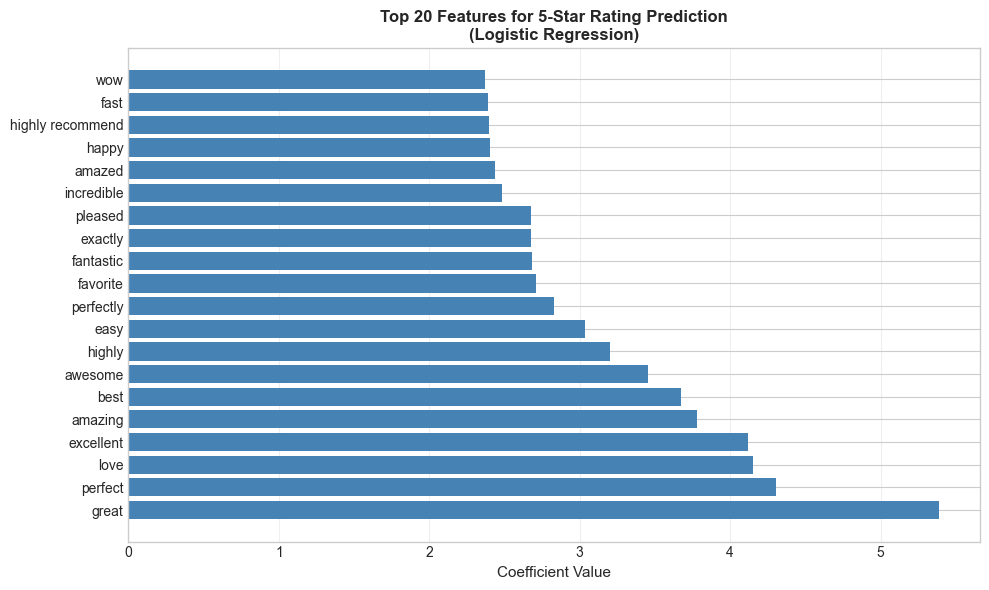


✅ Saved: feature_importance_nominal.png


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("=" * 70)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# For Logistic Regression: get top features per class
print("\n📊 Top 10 Most Important Features per Class (Logistic Regression):")
for class_idx, class_label in enumerate([1, 2, 3, 4, 5], 1):
    coef = lr_model.coef_[class_idx - 1]
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [(feature_names[i], coef[i]) for i in top_indices]
    print(f"\n   Class {class_label}⭐:")
    for feat, score in top_features:
        print(f"      {feat:20s} {score:+.4f}")

# Visualize feature importance for one class (e.g., 5-star)
fig, ax = plt.subplots(figsize=(10, 6))
class_5_coef = lr_model.coef_[4]  # 5-star is index 4
top_20_indices = np.argsort(class_5_coef)[-20:][::-1]
top_20_features = [feature_names[i] for i in top_20_indices]
top_20_scores = [class_5_coef[i] for i in top_20_indices]

bars = ax.barh(range(len(top_20_features)), top_20_scores, color='steelblue')
ax.set_yticks(range(len(top_20_features)))
ax.set_yticklabels(top_20_features)
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('Top 20 Features for 5-Star Rating Prediction\n(Logistic Regression)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/figures/feature_importance_nominal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: results/figures/feature_importance_nominal.png")

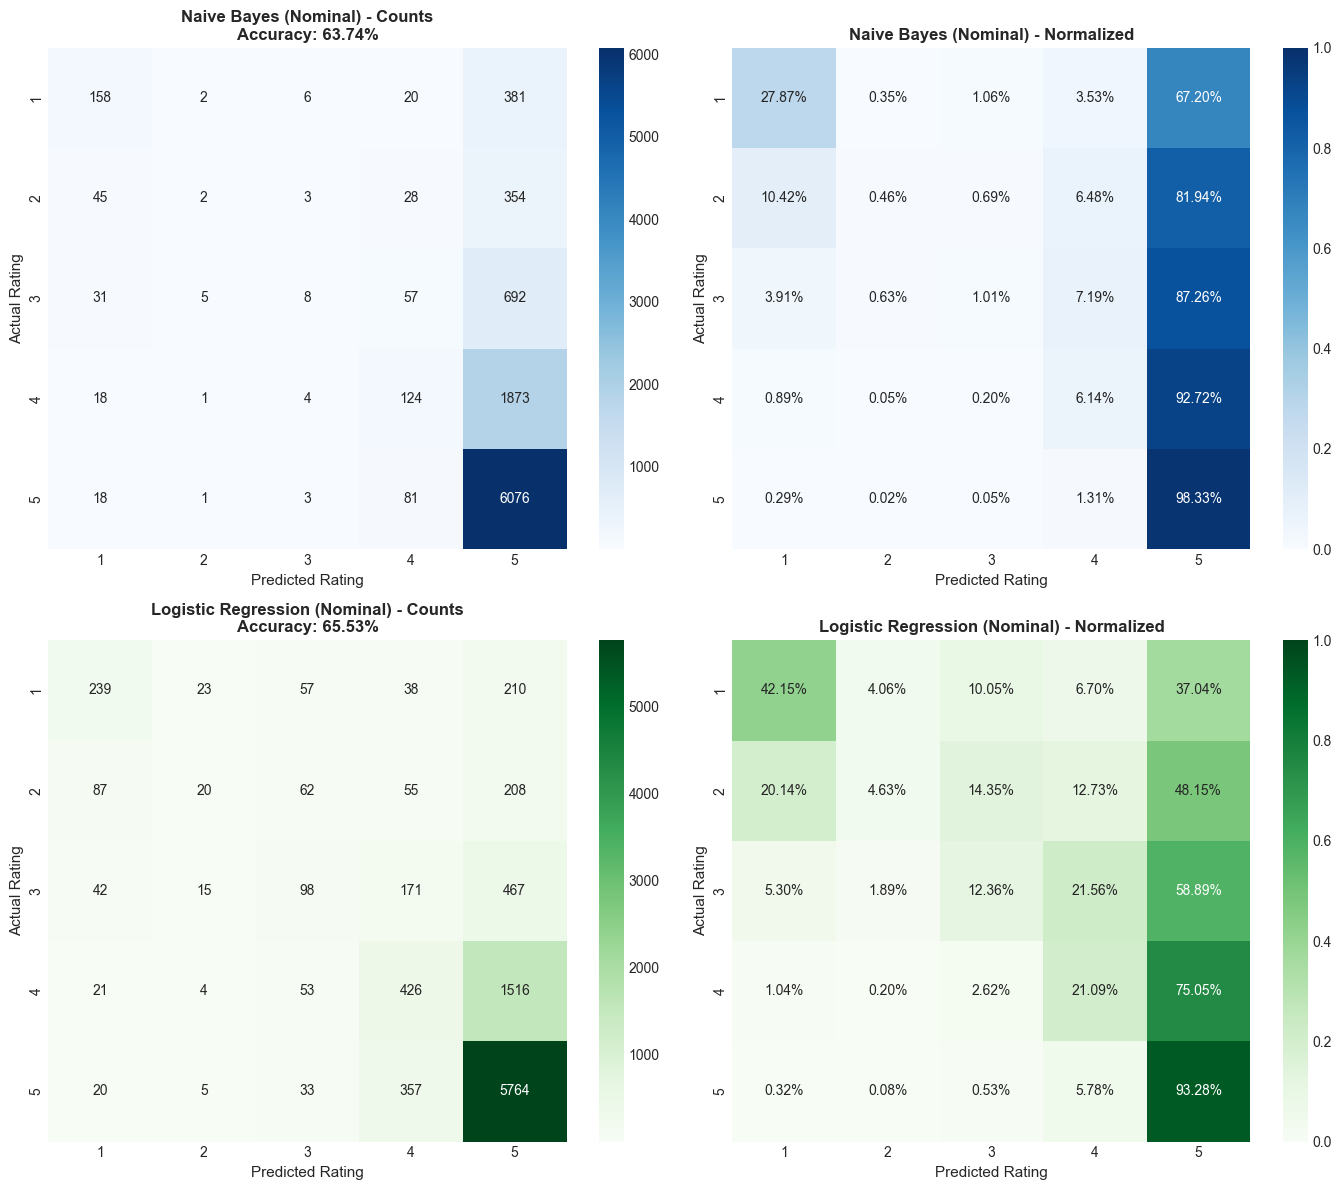


✅ Saved: confusion_matrices_nominal.png


In [ ]:
# ============================================================================
# CONFUSION MATRICES (Normalized)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Naive Bayes - Raw counts
cm_nb = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[0, 0].set_xlabel('Predicted Rating', fontsize=11)
axes[0, 0].set_ylabel('Actual Rating', fontsize=11)
axes[0, 0].set_title(f'Naive Bayes (Nominal) - Counts\nAccuracy: {nb_results["accuracy"]:.2%}', 
                  fontsize=12, fontweight='bold')

# Naive Bayes - Normalized
cm_nb_norm = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_nb_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[0, 1],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], vmin=0, vmax=1)
axes[0, 1].set_xlabel('Predicted Rating', fontsize=11)
axes[0, 1].set_ylabel('Actual Rating', fontsize=11)
axes[0, 1].set_title(f'Naive Bayes (Nominal) - Normalized', 
                  fontsize=12, fontweight='bold')

# Logistic Regression - Raw counts
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[1, 0].set_xlabel('Predicted Rating', fontsize=11)
axes[1, 0].set_ylabel('Actual Rating', fontsize=11)
axes[1, 0].set_title(f'Logistic Regression (Nominal) - Counts\nAccuracy: {lr_results["accuracy"]:.2%}', 
                  fontsize=12, fontweight='bold')

# Logistic Regression - Normalized
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_lr_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1, 1],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], vmin=0, vmax=1)
axes[1, 1].set_xlabel('Predicted Rating', fontsize=11)
axes[1, 1].set_ylabel('Actual Rating', fontsize=11)
axes[1, 1].set_title(f'Logistic Regression (Nominal) - Normalized', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/confusion_matrices_nominal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: results/figures/confusion_matrices_nominal.png")


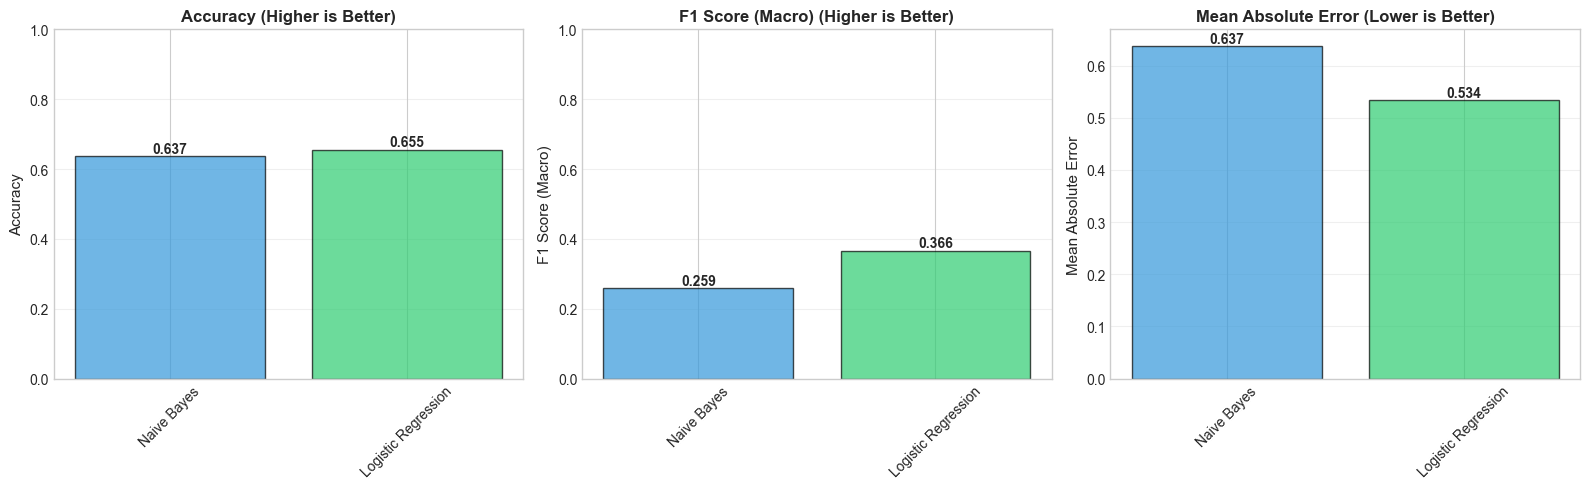


✅ Saved: model_comparison_nominal.png


In [ ]:
# ============================================================================
# MODEL COMPARISON VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['Naive Bayes', 'Logistic Regression']
metrics = ['accuracy', 'f1_macro', 'mae']
metric_labels = ['Accuracy', 'F1 Score (Macro)', 'Mean Absolute Error']
colors_comp = ['#3498db', '#2ecc71']

# Prepare data
nb_vals = [nb_results[m] for m in metrics]
lr_vals = [lr_results[m] for m in metrics]

x = np.arange(len(models))
width = 0.35

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    if metric == 'mae':
        # For MAE, lower is better, so we'll show it differently
        axes[idx].bar(models, [nb_results[metric], lr_results[metric]], 
                     color=colors_comp, alpha=0.7, edgecolor='black')
        axes[idx].set_ylabel(label, fontsize=11)
        axes[idx].set_title(f'{label} (Lower is Better)', fontsize=12, fontweight='bold')
    else:
        axes[idx].bar(models, [nb_results[metric], lr_results[metric]], 
                     color=colors_comp, alpha=0.7, edgecolor='black')
        axes[idx].set_ylabel(label, fontsize=11)
        axes[idx].set_title(f'{label} (Higher is Better)', fontsize=12, fontweight='bold')
        axes[idx].set_ylim([0, 1])
    
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (model, val) in enumerate(zip(models, [nb_results[metric], lr_results[metric]])):
        axes[idx].text(i, val + 0.01 if metric != 'mae' else val + 0.005, 
                      f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/model_comparison_nominal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: results/figures/model_comparison_nominal.png")


In [ ]:


# Combine results
nominal_results = pd.DataFrame([nb_results, lr_results])

print("\n" + "="*70)
print("📊 NOMINAL MODELS SUMMARY")
print("="*70)
print(nominal_results.to_string(index=False))

# Save to CSV
nominal_results.to_csv('results/tables/nominal_results.csv', index=False)
print("\n✅ Saved: results/tables/nominal_results.csv")


📊 NOMINAL MODELS SUMMARY
              model encoding  accuracy      mae  f1_macro  f1_weighted  precision_macro  recall_macro  training_time  precision_class_1  recall_class_1  f1_class_1  precision_class_2  recall_class_2  f1_class_2  precision_class_3  recall_class_3  f1_class_3  precision_class_4  recall_class_4  f1_class_4  precision_class_5  recall_class_5  f1_class_5  adjacent_error  severe_error
        Naive Bayes  Nominal  0.637374 0.637274  0.258764     0.528046         0.429675      0.267619       0.011017           0.585185        0.278660    0.377539           0.181818        0.004630    0.009029           0.333333        0.010088    0.019584           0.400000        0.061386    0.106438           0.648038        0.983331    0.781228        0.571350      0.428650
Logistic Regression  Nominal  0.655290 0.534081  0.366045     0.598661         0.463822      0.347025       3.996227           0.584352        0.421517    0.489754           0.298507        0.046296    0.080160

In [ ]:
# Save predictions for later analysis
predictions_df = pd.DataFrame({
    'actual': y_test,
    'nb_pred': nb_pred,
    'lr_pred': lr_pred
})
predictions_df.to_csv('results/tables/nominal_predictions.csv', index=False)
print("✅ Saved: results/tables/nominal_predictions.csv")

✅ Saved: nominal_predictions.csv
